In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float32
device ='cpu'

### 1. Introduction

---

The following notes on Sparse Gaussian Process methods and Structured Kernel Interpolation are based on the notation and general philosophy presented in:

- `[1]` Veit Wild, Motonobu Kanagawa, and Dino Sejdinovic. *Connections and Equivalences Between the Nyström Method and Sparse Variational Gaussian Processes*, 2023.
- `[2]` Andrew Gordon Wilson and Hannes Nickisch. *Kernel Interpolation for Scalable Structured Gaussian Processes (KISS-GP)*, 2015.

In particular, the theoretical characterization of Gaussian Processes as mathematical objects follows the treatment provided in `Section 2.2.1` of reference `[1]`. For additional detail regarding the mathematical intution for gaussian process methods we direct the reader to this work for futher reading

*As always when reading this notebook it is recommended to collapse all code cells and explore as needed.*

### 2. Problem statement `Regression` i.e *Function Approximation*

---

We first describe the regression problem. Let $\mathcal{X}$ be a non-empty set. Suppose we are given $n \in \mathbb{N}$ paired observations
$$
\left(x_1, y_1\right), \ldots,\left(x_n, y_n\right) \in \mathcal{X} \times \mathbb{R} .
$$

We assume that there exists a function $f_0: \mathcal{X} \rightarrow \mathbb{R}$ such that
$$
y_i=f_0\left(x_i\right)+\varepsilon_i, \quad i=1, \ldots, n .
$$
where $\varepsilon_1, \ldots, \varepsilon_n \in \mathbb{R}$ are independent, zero-mean, noise variables. This $f_0$ is called regression function. The task of regression is to estimate (or learn) $f_0$ from the training data $\left(x_i, y_i\right)_{i=1}^n$. We will often write $X:=\left(x_1, \ldots, x_n\right) \in \mathcal{X}^n$ and $y:=\left(y_1, \ldots, y_n\right) \in \mathbb{R}^n$.

### Experiment 1 : Toy 1-D example 

---

In this experiment we consider the function $\operatorname{sinc(x)}+\epsilon, \epsilon \sim \mathcal{N}(0, 0.04^2)$  Since this experiment is one-dimensional, it will operate as a grounding proof of concept for demonstrating that accurate 1-D interpolation is possible using the proposed regression methods covered in the following notebooks. 

All experiments will be CPU bound in `np.float64` bit percision to aid approximate positive semi definite caluclations in later notebooks. For Toy examples a **radial basis function** (RBF) kernel defined as 
$$k\left(x, x^{\prime}\right)=\exp \left(\frac{-\left\|x-x^{\prime}\right\|^2}{2 l^2}\right)$$
is used, whereas for higher dimensional data a Matern 3/2 kernel is used instead for numerical stability purposes 


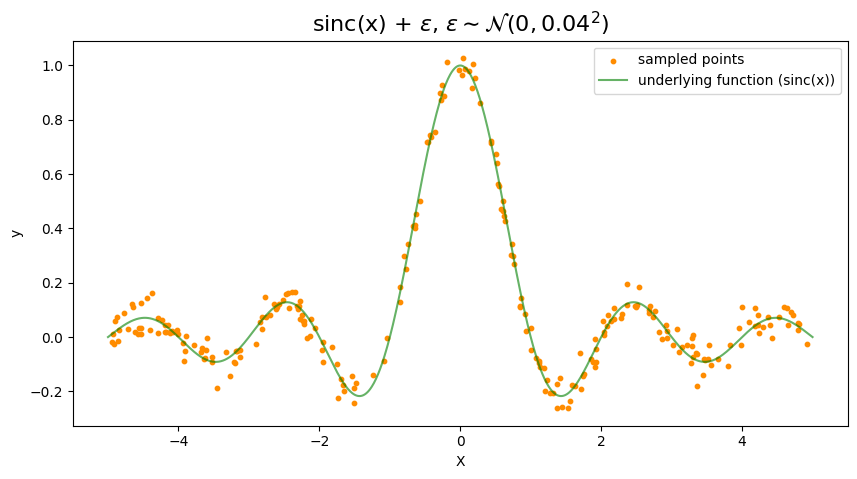

In [17]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 250

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


### 3. Basic **Gaussian Process Regression** (GPR)
---
GPR is a Bayesian nonparametric approach to the regression problem. In GPR, the regression function $f_0$  is the quantity of interest and modeled as a random function $F$. The prior distribution is given by a GP
$$
F \sim G P(m, k),
$$
where the mean function $m$ and covariance function $k$ are chosen to encode one's prior knowledge/assumption about the regression function $f_0$. The observation model of $F$ for the observations $y=\left(y_1, \ldots, y_n\right)^{\top}$ is given by
$$
y_i=F\left(x_i\right)+\varepsilon_i, \quad i=1, \ldots, n
$$
where $\varepsilon_i \sim \mathcal{N}\left(0, \sigma^2\right)$ is an independent Gaussian noise with variance $\sigma^2>0$.
By Bayes' rule, the posterior distribution of $F$ given $y$, under the prior $F\sim GP(m,k)$ is given by another GP (e.g., Rasmussen and Williams, 2006):
$$
F \mid y \sim G P(\bar{m}, \bar{k})
$$
where $\bar{k}: \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$ and $\bar{m}: \mathcal{X} \rightarrow \mathbb{R}$ are defined as
$$
\begin{aligned}
\bar{m}(x) & :=m(x)+k_X(x)^{\top}\left(k_{X X}+\sigma^2 I_n\right)^{-1}\left(y-m_X\right), \\
\bar{k}\left(x, x^{\prime}\right) & :=k\left(x, x^{\prime}\right)-k_X(x)^{\top}\left(k_{X X}+\sigma^2 I_n\right)^{-1} k_X\left(x^{\prime}\right),
\end{aligned}
$$

where $k_X(x)=\left(k\left(x_1, x\right), \ldots, k\left(x_n, x\right)\right)^{\top} \in \mathbb{R}^n$. We call $G P(\bar{m}, \bar{k})$ the posterior $G P, \bar{m}$ the posterior mean function and $\bar{k}$ the posterior covariance function. This expression can be directly implemented as follows:

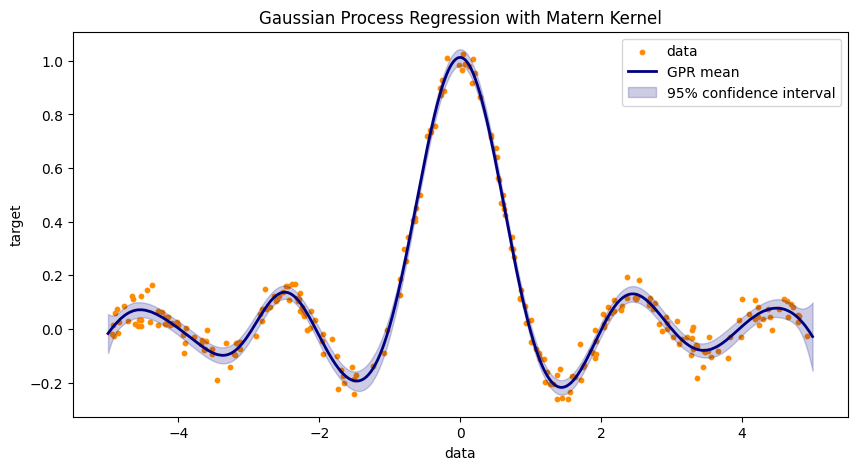

In [18]:
class GaussianProcessRegression:
    def __init__(self, lengthscale=1.0, sigma=0.1, dtype=global_dtype, kernel=None):
        self.sigma = sigma
        self.dtype = dtype
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale)

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype)
        y = y.to(dtype=self.dtype)
        K = self.kernel(X, X).to_dense() + self.sigma ** 2 * torch.eye(len(X), dtype=self.dtype)
        self.L = torch.linalg.cholesky(K)
        self.alpha = torch.cholesky_solve(y, self.L)

    def predict(self, X):
        X = X.to(dtype=self.dtype)
        K_trans = self.kernel(X, self.X_train).to_dense()
        K = self.kernel(X, X).to_dense()
        mean = K_trans @ self.alpha
        v = torch.cholesky_solve(K_trans.t(), self.L)
        covariance = K - K_trans @ v
        
        # Detach from the computation graph 
        mean_np = mean.detach().cpu().numpy()
        covariance_np = covariance.detach().cpu().numpy()
        
        return mean_np.squeeze(), covariance_np

lengthscale = 0.01 #Kernel bandwidth
sigma = 0.05 #Noise
gpr = GaussianProcessRegression(kernel=RBFKernel, sigma=sigma, dtype=global_dtype)
gpr.fit(train_data, train_labels)
GP_mean, GP_covariance = gpr.predict(test_data)
std = np.sqrt(np.diag(GP_covariance))

plt.figure(figsize=(10, 5))
plt.scatter(train_data.cpu().numpy(), train_labels.cpu().numpy(), s=10,color='darkorange', label='data')
plt.plot(test_data.cpu().numpy(), GP_mean, color='navy', lw=2, label='GPR mean')
plt.fill_between(test_data.cpu().numpy().ravel(), GP_mean - 1.96 * std, GP_mean + 1.96 * std, color='navy', alpha=0.2, label='95% confidence interval')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Gaussian Process Regression with Matern Kernel')
plt.legend()
plt.show()


### 4. Time Complexity

---

What is the operational complexity of running an exact Gaussian Process Regression (GPR)? To investigate this question, we can procedurally break down the cost of each part of GPR. Here we take the variable $Y$ to be the number of test points used during inference. Typically $Y<n$
<center>

### Time Complexity of Exact Gaussian Process Regression (GPR)

| **Step**       | **Operation**                                          | **Complexity**          |
|-----------------|--------------------------------------------------------|-------------------------|
| **Fitting**     | Kernel Computation (RBF Kernel and dense matrix)     | $\mathcal{O}(n^2)$    |
|                 | Cholesky Decomposition                                | $\mathcal{O}(n^3)$    |
|                 | Cholesky Solve                                        | $\mathcal{O}(n^2)$    |
| **Inference**   | Kernel Computation for Predictions                    | $\mathcal{O}(nY)$    |
|                 | Solving Linear Systems with Cholesky Factor           | $\mathcal{O}(nY)$    |
</center>

**Summary**:  
- **Fitting**: Dominated by $\mathcal{O}(n^3)$ due to Cholesky decomposition.  
- **Inference**: $\mathcal{O}(nY)$ for kernel computation and solving linear systems.  

For large datasets, the cubic complexity in fitting and linear complexity in inference can be prohibitive. This has led to approximate methods such as Sparse Gaussian Processes and Variational Approximations.



